<a href="https://colab.research.google.com/github/fintechsteve/modeling-volatility/blob/master/Part_04b_Creating_Turbulence_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Part 04 (b): Creating a Turbulence Model

### In this section you will:


*   Create a turbulence function that estimates turbulence with a rolling window.
*   Transform a turbulence signal into set of dynamic weights. Track performance of the model.
*   Optimize the lookback and smoothing window.


## Import all necessary libraries

For this piece, we will need the following packages to be available to our environment:

*   Numpy and Pandas (For data manipulation)
*   DateTime (For basic date manipulation)
*   Matplotlib (For timeseries vizualization)

If the packages are not available, install the with "pip install X"

In [1]:
import numpy as np, pandas as pd
from datetime import datetime, timedelta
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import bisect
from scipy import stats
import seaborn as sns

### Read in data from previously stored returns.pkl file



In [2]:
with open('./returns.pkl', 'rb') as f:
    returns = pickle.load(f)
    f.close()
returns.head(10)

,AUD,CAD,CHF,EUR,GBP,JPY,NOK,NZD,SEK
1975-01-02,-0.002129,-1.712061e-03,-0.009915,-0.003544,-0.005745,-0.001502,-0.003299,0.000536,-0.004704
1975-01-03,-0.000947,1.517425e-05,0.008500,0.007886,0.003424,0.002711,0.008801,-0.001924,0.007113
1975-01-06,-0.001158,6.677374e-04,-0.001023,0.008174,0.002346,-0.004728,0.002759,-0.001129,0.009237
1975-01-07,0.004193,-1.726304e-03,0.001702,0.002150,0.001702,0.002410,0.005434,0.004567,-0.001466
1975-01-08,-0.001489,-2.000930e-04,-0.015237,-0.008650,-0.001997,0.000122,-0.006315,-0.000034,-0.006188
1975-01-09,-0.000324,-3.120108e-03,0.000298,0.004764,0.000298,-0.000409,-0.000114,-0.001217,-0.000751
1975-01-10,0.000077,-1.283429e-03,0.001489,0.001489,0.001489,0.000075,0.006256,0.000311,0.001489
1975-01-13,0.000579,-3.152212e-07,0.001789,-0.001210,0.000127,-0.000578,0.000542,0.000969,-0.002488
1975-01-14,-0.000699,7.303998e-04,-0.005132,-0.006698,-0.001827,0.000291,-0.006558,-0.000762,-0.007795
1975-01-15,-0.000934,1.198868e-03,-0.002078,0.001797,-0.000426,-0.002542,-0.002276,-0.000594,0.000094


### Create a function that calculates turbulence for the whole window supplied using the last row as the observed return

Note that for faster computation we can replace ``` np.linalg.pinv(covmat)@(r - mu) ``` with ``` np.linalg.lstsq(covmat, r - mu)[0] ```

Also note that a more proper calculation of turbulence would only use rows 1:n-1 to calculate mean and covariance. But everybody seems to include n, so we aren't going to get upset here because it is simpler.

In [3]:
def simple_turbulence(rets):
  meanret = rets.mean()
  covrets = rets.cov()
  turbvalue = pd.DataFrame((rets[-1:]-meanret)@np.linalg.lstsq(covrets,(rets[-1:]-meanret).T, rcond=None)[0],index=[rets.index[-1]])
  return turbvalue

In [4]:
turb_singleday = simple_turbulence(returns)
turb_singleday

CPU times: user 1 µs, sys: 1 µs, total: 2 µs
Wall time: 3.81 µs


,0
2017-12-26,1.944164


### Create a function that calculates rolling turbulence given a lookback window and a smoothing window

To do this, we are going to create a function ```roll``` that generates a rolling window of returns for a specified window length, and a function that applies the turbulence calculation to that window.

In [5]:
def roll(df, w):
    for i in range(df.shape[0] - w + 1):
        yield pd.DataFrame(df.values[i:i+w, :], df.index[i:i+w], df.columns)
  
def rolling_turbulence(rets, lookback=260, smoothing=20):
    roll_turb = pd.concat([simple_turbulence(retwindow) for retwindow in roll(rets, lookback)], axis=0)
    roll_turb.columns = ['daily']
    roll_turb_smooth = pd.DataFrame(roll_turb.rolling(smoothing).mean()).rename(columns={'daily':'smoothed'})
    rets = rets.join(roll_turb)
    rets = rets.join(roll_turb_smooth)
    return rets[['daily','smoothed']]

In [6]:
roll_turb = rolling_turbulence(returns, lookback=260, smoothing=20)
roll_turb.tail(20)

CPU times: user 21.2 s, sys: 113 ms, total: 21.4 s
Wall time: 21.4 s


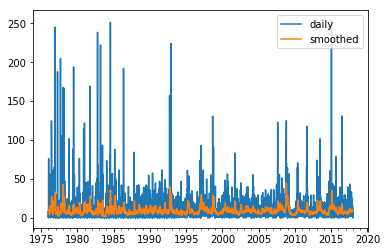

In [7]:
roll_turb.plot()

### Convert rolling turbulence into a weight (And do so in a function)

Turbulence as a raw statistic ranges between 0 and infinity. It cannot be directly used for investment strategies without some kind of transformation into model weights.

Our most obvious optiions are to create a binary cutoff or linear ranking. We are going to use linear ranking, though there are reasons why you might want to use a binary cutoff (simple on/off model).

The linear ranking, when used in-sample, should map results to a uniform distribution.

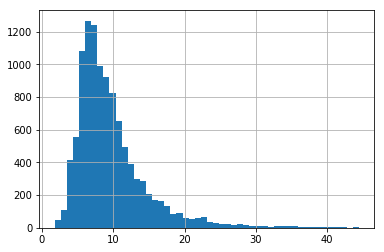

In [8]:
roll_turb['smoothed'].hist(bins=50)

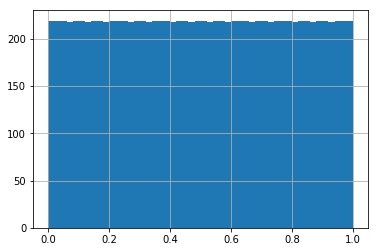

In [9]:
historical_turb_rank = roll_turb['smoothed'].dropna().rank()/roll_turb['smoothed'].count()
historical_turb_rank.hist(bins=50)

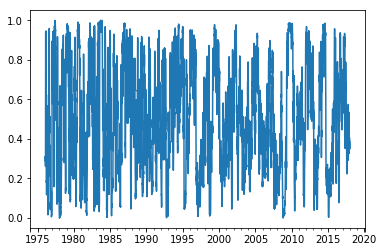

In [10]:
insample_start_date = '1975-01-02'
insample_end_date = '2000-01-01'
insample_turb = (roll_turb['smoothed'].loc[insample_start_date:insample_end_date]).dropna().values
insample_turb.sort()
num_insample = np.size(insample_turb)
roll_turb['ranked'] = 1-np.true_divide(list(map(lambda x:float('NaN') if np.isnan(x) else bisect.bisect_left(insample_turb,x), roll_turb['smoothed'])),num_insample)
roll_turb['ranked'].plot()

In [11]:
def turbulence_weights(roll_turb, insample_start_date, insample_end_date):
  insample_turb = (roll_turb['smoothed'].loc[insample_start_date:insample_end_date]).dropna().values
  insample_turb.sort()
  num_insample = np.size(insample_turb)
  turb_weights = pd.DataFrame(1-np.true_divide(list(map(lambda x:float('NaN') if np.isnan(x) else bisect.bisect_left(insample_turb,x), roll_turb['smoothed'])),num_insample), index=roll_turb.index)
  turb_weights.columns=['weights']
  return turb_weights

In [12]:
turb_weights = turbulence_weights(roll_turb, '1975-01-02', '2000-01-01')
turb_weights.tail(20)

,weights
2017-11-29,0.495195
2017-11-30,0.489270
2017-12-01,0.456278
2017-12-04,0.463645
2017-12-05,0.452594
2017-12-06,0.406470
2017-12-07,0.399103
2017-12-08,0.391576
2017-12-11,0.352178
2017-12-12,0.395099


### Quick sanity checks

1) Are the weights aligned with decreasing turbulence?
2) Does the weight inversely correlate with subsequent volatility?

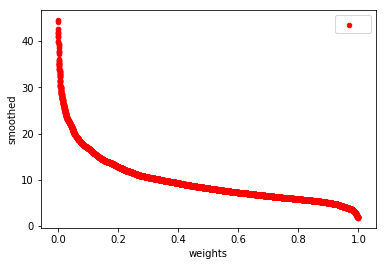

In [13]:
pd.concat([roll_turb, turb_weights],axis=1).plot(kind='scatter', x='weights', y='smoothed',
                                           color='Red', label='')

In [14]:
dxy_weight = [0, 0.119, 0.036, 0, 0.136, 0.576, 0, 0, 0.091]
dxy = pd.DataFrame(returns.dot(dxy_weight))
dxy_forward = dxy.shift(-1)
dxy_forward_sq = (dxy_forward**2).rename(columns={0:'dxyfsq'})

In [15]:
highturbulence = turb_weights['weights']<.25
pd.DataFrame([[np.sqrt(261)*dxy[highturbulence].std(), np.sqrt(261)*dxy[~highturbulence].std()], [sum(highturbulence), sum(~highturbulence)]], index=['std','N'], columns=['High Turb','Low Turb'])

,High Turb,Low Turb
std,0 0.090019 dtype: float64,0 0.070485 dtype: float64
N,2627,8587


### Calculate the performance of the turbulence model

Leveraging the framework we developed in Part 3, we calculate the excess performance of the model.


In [16]:
def model_perf(model_wts, dxyfsq, framework_params):
  # Note, since chapter 3, modified the code a little to handle the possibility that column headings are not constant
  # Also added an estimation window, which we will use later
    
  model_vol = pd.DataFrame()
  model_vol['total'] = model_wts[model_wts.columns[0]]*dxyfsq[dxyfsq.columns[0]] 
  model_vol['avg'] = (np.mean(model_wts.loc[framework_params['insample_start_date']:framework_params['insample_end_date']].dropna()[model_wts.columns[0]])*dxyfsq)

  is_model_vol = model_vol.loc[framework_params['insample_start_date']:framework_params['insample_end_date']].dropna() 
  is_vol_rmse = np.sqrt(np.mean(is_model_vol))

  out_model_vol = model_vol.loc[framework_params['outofsample_start_date']:framework_params['outofsample_end_date']].dropna()
  out_vol_rmse = np.sqrt(np.mean(out_model_vol))
  
  model_perf_stats = {'insample rmse': is_vol_rmse['total'], 'insample excess rmse': is_vol_rmse['total'] - is_vol_rmse['avg'],
                        'out-of-sample rmse': out_vol_rmse['total'], 'out-of-sample excess rmse': out_vol_rmse['total'] - out_vol_rmse['avg']}
    
  if framework_params.get('estimationsample_start_date'):
    est_model_vol = model_vol.loc[framework_params['estimationsample_start_date']:framework_params['estimationsample_end_date']].dropna()
    est_vol_rmse = np.sqrt(np.mean(est_model_vol))
    model_perf_stats['estimation rmse'] = est_vol_rmse['total']
    model_perf_stats['estimation excess rmse'] = est_vol_rmse['total'] - est_vol_rmse['avg']
        
  if framework_params.get('verbose',False):
    model_perf_stats['insample model volatility'] = is_model_vol
    model_perf_stats['out-of-sample model volatility'] = out_model_vol
    
  return model_perf_stats

In [17]:
framework_params = {'insample_start_date': '1975-01-02',
                    'insample_end_date': '2000-01-01',
                    'outofsample_start_date': '2000-01-02',
                    'outofsample_end_date': '2017-12-26',
                    'verbose': False}

model_perf(turb_weights, dxy_forward_sq, framework_params)

{'insample rmse': 0.003233913057816355,
 'insample excess rmse': -0.00022350394266198916,
 'out-of-sample rmse': 0.0029439065157343116,
 'out-of-sample excess rmse': -0.00021882194541095017}

## Test significance of excess volatility

A simple test of the ability of a turbulence model to outperform a random model is to calculate the significance of the average excess volatility.

We want this statistic to be negative, because a good model should reduce volatility.

We can calculate this by looking at the difference between the volatility for the model and the volatility of a model that assigns an average weight to volatility and calculating a t-statistic:

In [18]:
framework_params = {'insample_start_date': '1975-01-02',
                    'insample_end_date': '2000-01-01',
                    'outofsample_start_date': '2000-01-02',
                    'outofsample_end_date': '2017-12-26',
                    'verbose': True}

model_perf_stats = model_perf(turb_weights, dxy_forward_sq, framework_params)

stats.ttest_rel(model_perf_stats['insample model volatility']['total'], model_perf_stats['insample model volatility']['avg'])


Ttest_relResult(statistic=-5.683095936183485, pvalue=1.3825260997268557e-08)

In [19]:
stats.ttest_rel(model_perf_stats['out-of-sample model volatility']['total'], model_perf_stats['out-of-sample model volatility']['avg'])

Ttest_relResult(statistic=-6.578732513461949, pvalue=5.2636507159142104e-11)

### Grid search for the optimal parameters

We chose a smoothing window of 20 days and a lookback of 260 days. How do we pick the correct parameters?

We need to be careful about holdback periods with this kind of analysis. Let's start by being careful with our sample windows.

### Splitting the sample for hyperparameter tuning

We will limit ourselves to the following sample windows:

insample_start_date: '1975-01-02'
insample_end_date: '1994-12-31'
estimationsample_start_date: '1995-01-01'
estimationsample_end_date: '2004-12-31'
outofsample_start_date: '2005-01-01'
outofsample_end_date: '2017-12-26'

In [20]:
framework_params = {'insample_start_date': '1975-01-02',
                    'insample_end_date': '1994-12-31',
                    'estimationsample_start_date': '1995-01-01',
                    'estimationsample_end_date': '2004-12-31',
                    'outofsample_start_date': '2005-01-01',
                    'outofsample_end_date': '2017-12-26',
                    'verbose': False}

def turbulence_models_performance(rets, framework_params, lookback, smoothing):
  roll_turb_signal = rolling_turbulence(rets, lookback=lookback, smoothing=smoothing)
  turb_wts = turbulence_weights(roll_turb_signal, framework_params['insample_start_date'], framework_params['insample_end_date'])
  model_perf_stats = model_perf(turb_wts, dxy_forward_sq, framework_params)
  return {'model_perf_stats':model_perf_stats, 'turb_wts':turb_wts}

some_model_perf_stats = turbulence_models_performance(returns, framework_params, 260, 20)
some_model_perf_stats['model_perf_stats']

{'insample rmse': 0.00323959374154902,
 'insample excess rmse': -0.00014603009956524592,
 'out-of-sample rmse': 0.0029791991383896726,
 'out-of-sample excess rmse': -0.00022752335244280095,
 'estimation rmse': 0.003003252150698102,
 'estimation excess rmse': -0.00039474797662171837}

We will run for the following lookback windows:
65 days (1 Quarter), 130 days (Half year), 260 days (1 year), 390 days (1.5 years), 520 days (2 years)

and the following smoothing windows:
1 day (daily), 5 days (weekly), 10 days (fortnightly), 20 days (monthishly), 40 days (bimonthly)

**Note this takes a little time to run for all 25 models**

In [21]:
lookbacks = [65,130,260,390,520]
smoothings = [1, 5, 10, 20, 40]

index = pd.MultiIndex.from_product([lookbacks,smoothings],names=['lookbacks','smoothings'])

turb_model_perf_stats = pd.DataFrame(index = index, columns = some_model_perf_stats['model_perf_stats'].keys())
turb_model_weights = pd.DataFrame(index = returns.index, columns = index)

for lookback in lookbacks:
  for smoothing in smoothings:
    model_output = turbulence_models_performance(returns, framework_params, lookback=lookback, smoothing=smoothing)
    turb_model_perf_stats.loc[(lookback,smoothing)] = model_output['model_perf_stats']
    turb_model_weights.loc[:,(lookback,smoothing)] = model_output['turb_wts']['weights']

turb_model_perf_stats

CPU times: user 8min 55s, sys: 2.28 s, total: 8min 57s
Wall time: 8min 57s


In [22]:
turb_model_weights.tail(20)

lookbacks        65                                                130  \
smoothings        1         5         10        20        40        1    
2017-11-29  0.311275  0.573509  0.646384  0.613362  0.625147  0.239780   
2017-11-30  0.105764  0.381822  0.539269  0.609466  0.576848  0.128341   
2017-12-01  0.116825  0.227423  0.445373  0.577717  0.518772  0.153302   
2017-12-04  0.852319  0.269761  0.446345  0.590183  0.526985  0.802869   
2017-12-05  0.647972  0.285298  0.444984  0.562914  0.517990  0.685535   
2017-12-06  0.241995  0.267236  0.411353  0.534086  0.480837  0.185142   
2017-12-07  0.688919  0.475044  0.449456  0.551811  0.506648  0.543632   
2017-12-08  0.494081  0.693339  0.431765  0.521231  0.528158  0.625983   
2017-12-11  0.250922  0.487473  0.363919  0.481106  0.495698  0.166470   
2017-12-12  0.207064  0.341231  0.302488  0.504090  0.468322  0.229756   
2017-12-13  0.523190  0.436978  0.334565  0.512466  0.475362  0.423742   
2017-12-14  0.199690  0.298505  0.383942  0.492209  0.517990  0.233294   
2017-12-15  0.556763  0.308992  0.503110  0.507012  0.533242  0.426887   
2017-12-18  0.262371  0.313070  0.407854  0.450331  0.494916  0.303656   
2017-12-19  0.807297  0.480287  0.426905  0.462992  0.506648  0.845519   
2017-12-20  0.296332  0.405904  0.440902  0.448968  0.543801  0.350629   
2017-12-21  0.297108  0.453680  0.373445  0.435333  0.549863  0.305621   
2017-12-22  0.560644  0.454846  0.383942  0.430269  0.571373  0.439662   
2017-12-25  0.995343  0.723441  0.520801  0.473120  0.585452  0.995283   
2017-12-26  0.878129  0.743445  0.658631  0.497663  0.598162  0.920008   

lookbacks                                             ...          390  \
smoothings        5         10        20        40    ...           1    
2017-11-29  0.524980  0.563300  0.568751  0.550406    ...     0.383596   
2017-11-30  0.362313  0.506990  0.571908  0.526837    ...     0.097556   
2017-12-01  0.259048  0.462493  0.542513  0.496732    ...     0.160936   
2017-12-04  0.275964  0.465249  0.551588  0.502278    ...     0.754971   
2017-12-05  0.314713  0.475290  0.539554  0.501089    ...     0.690762   
2017-12-06  0.288552  0.412877  0.493786  0.465637    ...     0.138567   
2017-12-07  0.443155  0.419768  0.487867  0.479105    ...     0.485501   
2017-12-08  0.632966  0.433156  0.474058  0.501089    ...     0.693662   
2017-12-11  0.417978  0.354007  0.430460  0.469400    ...     0.131732   
2017-12-12  0.311369  0.318370  0.472677  0.452367    ...     0.144159   
2017-12-13  0.385523  0.350856  0.477214  0.451575    ...     0.435377   
2017-12-14  0.310582  0.385509  0.471296  0.491979    ...     0.193455   
2017-12-15  0.276751  0.447332  0.486092  0.502872    ...     0.370961   
2017-12-18  0.328482  0.387872  0.450582  0.481481    ...     0.286040   
2017-12-19  0.473249  0.404213  0.465772  0.496732    ...     0.874275   
2017-12-20  0.455350  0.443591  0.455317  0.532581    ...     0.266984   
2017-12-21  0.489575  0.408742  0.438153  0.538721    ...     0.227423   
2017-12-22  0.493509  0.387675  0.432235  0.551000    ...     0.228045   
2017-12-25  0.699646  0.519984  0.457289  0.561695    ...     0.997929   
2017-12-26  0.721873  0.637527  0.487670  0.576352    ...     0.829950   

lookbacks                                                520            \
smoothings        5         10        20        40        1         5    
2017-11-29  0.619403  0.590786  0.581202  0.617665  0.358238  0.619088   
2017-11-30  0.407960  0.525835  0.551882  0.561913  0.110685  0.427993   
2017-12-01  0.324834  0.482880  0.525265  0.529338  0.209238  0.364721   
2017-12-04  0.319030  0.482880  0.534415  0.532261  0.743295  0.355986   
2017-12-05  0.329187  0.504669  0.524849  0.531217  0.740102  0.374521   
2017-12-06  0.249171  0.414816  0.466209  0.497599  0.156024  0.295910   
2017-12-07  0.395108  0.418967  0.459347  0.508666  0.500639  0.447380   
2017-12-08  0.573383  0.455904  0.451445  0.523909  0.714559  0.603749   
20

In [28]:
turb_model_weights.to_pickle('./turb_model_weights.pkl')
turb_model_perf_stats.to_pickle('./turb_model_perf_stats.pkl')

### Evaluating the out of sample performance of the optimal model

We plan on taking the model with the lowest estimation period excess RMSE as the optimal parameterization.

Let's look at how well this aligns during the out of sample period.

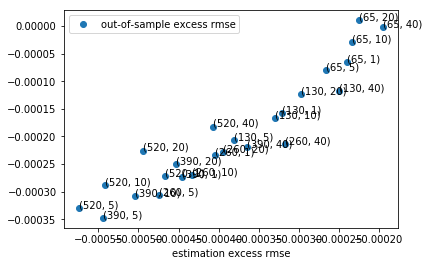

In [24]:
fig, ax = plt.subplots()
turb_model_perf_stats.plot(x='estimation excess rmse', y='out-of-sample excess rmse', ax=ax, style='o')

for k, v in turb_model_perf_stats.iterrows():
  ax.annotate(k, (v['estimation excess rmse'],v['out-of-sample excess rmse']))

There is a strong (but by no means 1:1) relationship between performance in the estimation window and out of sample, suggesting that these models exhibit persistent performance associated with paramater choices.

### Exploring a bad idea in a little more detail...

Suppose instead we had used the insample performance to choose the best model.

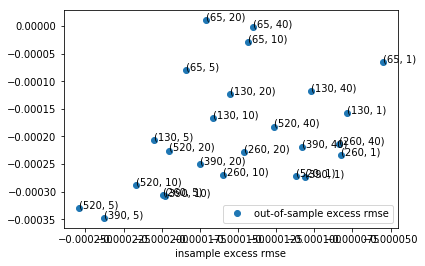

In [25]:
fig, ax = plt.subplots()
turb_model_perf_stats.plot(x='insample excess rmse', y='out-of-sample excess rmse', ax=ax, style='o')

for k, v in turb_model_perf_stats.iterrows():
  ax.annotate(k, (v['insample excess rmse'],v['out-of-sample excess rmse']))

While there is a positive relationship between the two, the relationship is weaker. This is because we are overfitting in sample.

**In sample performance should never be used to determine the correct parameterization of a model.**

### Sanity checking with random returns

Before you get too far with any model, it is worthwhile testing how your model performs if the inputs are randomized. This is a good way of identifying information leakage inside the model code.

To do this with turbulence, we are going to simulate 1000 random samples of returns, calculate turbulence on these simulated returns and look at the relationship to subsequent simulated DXY. If we use IID normal returns, there should be no predictive power out of sample.

** Note: This step takes a while to run, depending on computational power **

In [ ]:
framework_params = {'insample_start_date': '1975-01-02',
                    'insample_end_date': '2000-01-01',
                    'outofsample_start_date': '2000-01-02',
                    'outofsample_end_date': '2017-12-26',
                    'verbose': False}

def random_turbulence_models_by_seed(rets,framework_params, seed):
  np.random.seed(seed=seed)
  randreturns = pd.DataFrame(np.random.randn(rets['AUD'].count(),9), index=rets.index, columns=rets.columns)
  roll_turb_signal = rolling_turbulence(randreturns, lookback=260, smoothing=20)
  turb_wts = turbulence_weights(roll_turb_signal, framework_params['insample_start_date'], framework_params['insample_end_date'])
  model_perf_stats = model_perf(turb_wts, dxy_forward_sq, framework_params)
  return model_perf_stats

# random_turbulence_models_by_seed(returns,framework_params, 1)

rand_turb_perf = pd.DataFrame(list(map(lambda x:random_turbulence_models_by_seed(returns, framework_params, x), range(0,1000))))

In [32]:
rand_turb_perf.describe()

,insample excess rmse,insample rmse,out-of-sample excess rmse,out-of-sample rmse
count,1000.000000,1000.000000,1.000000e+03,1000.000000
mean,-0.000002,0.003455,-1.457792e-06,0.003161
std,0.000046,0.000046,4.652084e-05,0.000047
min,-0.000141,0.003317,-1.371522e-04,0.003026
25%,-0.000032,0.003425,-3.147497e-05,0.003131
50%,-0.000002,0.003456,9.324964e-07,0.003164
75%,0.000027,0.003485,2.929593e-05,0.003192
max,0.000140,0.003597,1.443963e-04,0.003307


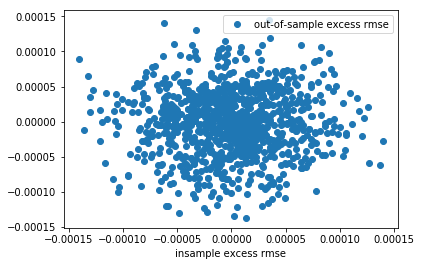

In [34]:
rand_turb_perf.plot(x='insample excess rmse', y='out-of-sample excess rmse', style='o')

There is no discernable pattern of performance either in- or out-of-sample.

In [33]:
rand_turb_perf.to_pickle('./rand_turb_perf.pkl')